# 2. Cell Classifier
This note book is for classifying cells in the first BMC data set, annotated by Felicia.

In [1]:
import os
from pathlib import Path
import random
import numpy as np

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

import keras
from keras.utils import Sequence
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from weighted_loss_unet import make_weighted_loss_unet, my_loss

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageStat
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import json
import pandas as pd

import utils
from weighted_loss_unet import make_weighted_loss_unet, my_loss
import config
c = config.Config()

## Investigating data

In [2]:
from dataset import TNBC1
df = TNBC1().get_dataframe()
df['class'].value_counts()

tumor           658
immune cells    593
stroma          421
rbc              30
necrosis          6
Name: class, dtype: int64

In [3]:
# Dropping necrosis and rbc and stroma
df = df[df['class'] != 'rbc']
df = df[df['class'] != 'necrosis']
df = df[df['class'] != 'stroma']

In [4]:
def normalize_vertices(vertices):
    (x_min,y_min), (_, _) = utils.bounding_box(vertices)
    return [(x - x_min, y - y_min) for x, y in vertices]

def _bbox_to_slice(bbox):
    return (slice(int(bbox[0][1]), int(bbox[1][1]), None), 
            slice(int(bbox[0][0]), int(bbox[1][0]), None))

def generate_mask(vertices):
    img = Image.new("L", (3000, 3000), 0)
    ImageDraw.Draw(img).polygon(vertices, outline=1, fill=1)
    (left, upper), (right, lower) = utils.bounding_box(vertices)
    img = img.crop((left, upper, right+1, lower+1))
    return np.asarray(img)

df['vertices normalized'] = df['vertices'].apply(normalize_vertices)
df["obj"] = df["vertices"].apply(lambda x: _bbox_to_slice(utils.bounding_box(x)))
df['mask'] = df['vertices'].apply(generate_mask)
df['size'] = df['mask'].apply(np.sum)
df = df[df['size'] != 0]

Text(0.5, 1.0, 'Major and minor axis ratio')

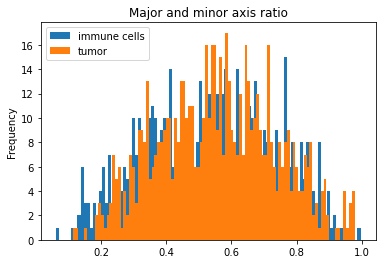

In [5]:
# Exploring major and minor axis
# https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

def major_minor_axis(mask):
    if np.sum(mask) < 2:
        return 0, 0
    y, x = np.nonzero(mask)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
    v2, v1 = np.sort(evals)
    return v1, v2

df['major axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[0])
df['minor axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[1])
df['axis ratio'] = df['minor axis'] / df['major axis']
df.groupby('class')['axis ratio'].plot.hist(bins = 100)
plt.legend()
plt.title('Major and minor axis ratio')

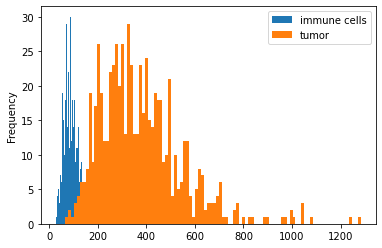

In [6]:
# Size Size varies between classes
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100)
plt.legend()

In [7]:
def brightness_mean(im):
    return np.nanmean(np.ravel(np.where(im!=0,im,np.nan)))
        
def brightness_var(im):
    return np.var(np.ravel(im))
    
    
def avg_brightness(ids, masks, obj, image_dict):
    avg = []
    var = []
    
    for imid, mask, obj in zip(ids, masks, obj):
        img = image_dict[imid][obj]
        mask = mask[:img.shape[0], :img.shape[1]]
        img = img[:mask.shape[0], :mask.shape[1], :]
        img = img * np.dstack((mask, mask, mask))
        m = brightness_mean(img)
        v = brightness_var(img)
        
        if m is None or v is None:
            avg.append(0)
            var.append(0)
        else:
            avg.append(m)
            var.append(v)
    return avg, var

Text(0.5, 1.0, 'Brightness variance')

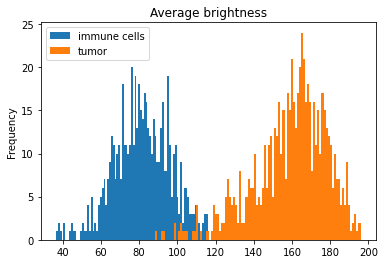

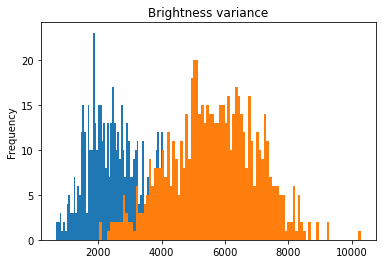

In [8]:
tnbc = TNBC1()
image_dict = dict([(imid, tnbc.load_image(imid)) for imid in tnbc.ids])
df["avg_brightness"], df["var_brightness"] = avg_brightness(df["image_id"], df["mask"], df["obj"], image_dict)
df.groupby('class')["avg_brightness"].plot.hist(bins=100)
plt.legend()
plt.title("Average brightness")
plt.figure()
df.groupby('class')["var_brightness"].plot.hist(bins=100)
plt.title("Brightness variance")

## Training basic model
We've found that the size, and brightness differ between classes. We will use these as features.


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import time

features = ['avg_brightness', 'var_brightness', 'size']
classes = ['tumor', 'immune cells']
df_class = pd.get_dummies(df['class'])
df_features = pd.concat([df_class, df[features]], axis=1)

np.random.seed(0) # Set random seed for test/train-split
msk = np.random.rand(len(df_features)) < 0.8
df_test = df_features[~msk]
df_train = df_features[msk]

X = df_train[features]
y = df_train[classes]

kf = KFold(n_splits=5,shuffle=True)
kf.split(X)

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)
cm_list = []
for train_index, val_index in kf.split(X):
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val).argmax(axis=1)
    y_val = y_val.values.argmax(axis=1)
    cm_list.append(confusion_matrix(y_val, y_pred, normalize='true'))


### Evaluation
The validation scores seem pretty promesing.

<AxesSubplot:>

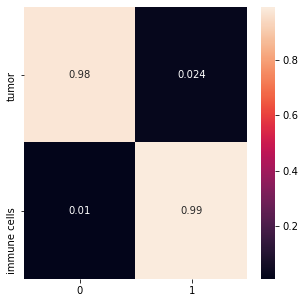

In [10]:
import seaborn as sn
df_cm = pd.DataFrame(np.mean(cm_list, axis=0), index = classes)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)

## Classifying masks predicted by U-Net

In [11]:
def iou():
    pass

def _reshape_to_batch(patch):
    n = int(np.sqrt(c.BATCH_SIZE))
    batch = []
    for col in np.array_split(patch,n, axis=0):
        for b in np.array_split(col,n, axis=1):
            batch.append(b)
    return np.asarray(batch)
            
def _reshape_to_patch(batch):
    n = int(np.sqrt(c.BATCH_SIZE))
    patch = np.zeros((n * c.HEIGHT, n * c.WIDTH))
    i = 0
    for y in range(0, n * c.HEIGHT, c.HEIGHT):
        for x in range(0, n * c.WIDTH, c.WIDTH):
            patch[y:y+c.HEIGHT, x:x+c.WIDTH]  = batch[i,...]
            i += 1
    return patch

In [26]:
from skimage.transform import resize
from joblib import Memory
from time import time
from scipy.ndimage import find_objects
from skimage import measure
from skimage import segmentation
from skimage import morphology

memory = Memory('./cache', verbose=False)

def post_processing(prediction, p = [0.08, 20, 3]):
    prediction = (prediction > p[0])
    prediction = morphology.remove_small_holes(prediction, area_threshold=p[1])
    #prediction = morphology.remove_small_objects(prediction, min_size=p[2])
    prediction = morphology.dilation(prediction, morphology.square(int(p[2])))
    return prediction

@memory.cache
def make_pred(img_path, model_name, stride):
    model = keras.models.load_model(c.MODEL_DIR / f'unet/{model_name}.h5',
                    custom_objects={'my_loss' : my_loss, 'iou': iou}, compile=False)
    img = imread(img_path)
    #scale = 2
    #img = resize(img, (img.shape[0]*scale, img.shape[1]*scale)) * 255
    
    b_width = int(np.sqrt(c.BATCH_SIZE))
    pred = np.zeros(img.shape[0:2])
    norm_mat = np.ones_like(pred)
    for y in range(0, pred.shape[1], stride):
        for x in range(0, pred.shape[0], stride):
            t0 = time()
            img_patch = img[y:y + b_width * c.HEIGHT, x:x + b_width * c.WIDTH]
            batch_patch = np.zeros((b_width * c.HEIGHT, b_width * c.HEIGHT, c.CHANNELS))
            batch_patch[:img_patch.shape[0], :img_patch.shape[1]] = img_patch
            batch = _reshape_to_batch(batch_patch)
            pred_batch = model.predict(batch)[...,1]
            pred_patch = _reshape_to_patch(pred_batch)
            pred[y:y+ b_width * c.HEIGHT, x:x + b_width * c.WIDTH] += pred_patch[:img_patch.shape[0], :img_patch.shape[1]]
            norm_mat[y:y + b_width * c.HEIGHT, x:x + b_width * c.WIDTH] += 1
    
    pred = pred / norm_mat
    return pred
    #return resize(pred, (int(img.shape[0]/scale), int(img.shape[1]/scale)))

In [13]:
masks = {}
tnbc = TNBC1()
for im_id in tqdm(df["image_id"].unique(), desc="Making masks"):
    path = tnbc.file_name(im_id)
    masks[im_id] = post_processing(make_pred(path, 'unet_quip_10000', int(c.WIDTH*3/2)))

Making masks: 100%|██████████| 80/80 [01:03<00:00,  1.26it/s]


In [14]:
df = df[df["image_id"].isin(masks.keys())]
df["unet_mask"] = df.apply(lambda x: masks[x.image_id][x.obj], axis=1)
df["unet_avg_brightness"], df["unet_var_brightness"] = avg_brightness(df["image_id"], df["unet_mask"], df["obj"], image_dict)
df["unet_size"] = df["unet_mask"].apply(np.sum)

<ipython-input-7-721f1a0bf6dd>:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im!=0,im,np.nan)))


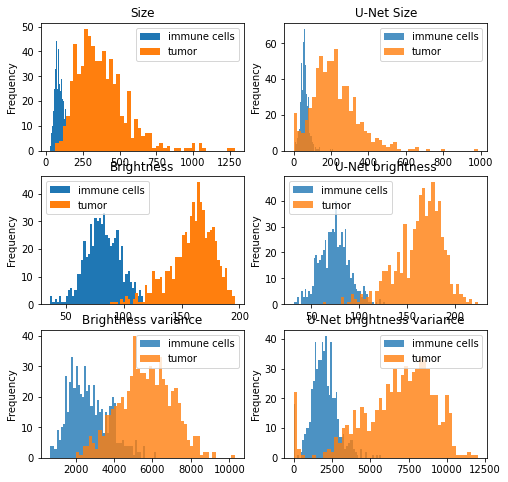

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(321)
df.groupby("class")["size"].plot.hist(bins=50)
plt.title("Size")
plt.legend()
plt.subplot(322)
df.groupby("class")["unet_size"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net Size")
plt.legend()
plt.subplot(323)
df.groupby("class")["avg_brightness"].plot.hist(bins=50)
plt.title("Brightness")
plt.legend()
plt.subplot(324)
df.groupby("class")["unet_avg_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net brightness")
plt.legend()
plt.subplot(325)
df.groupby("class")["var_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("Brightness variance")
plt.legend()
plt.subplot(326)
df.groupby("class")["unet_var_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net brightness variance")
plt.legend()

<Figure size 432x288 with 0 Axes>

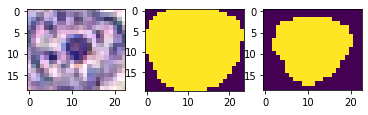

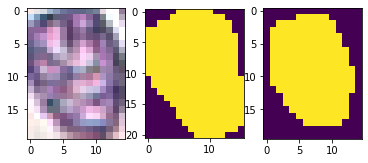

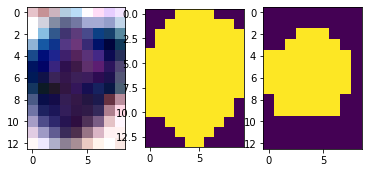

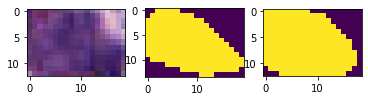

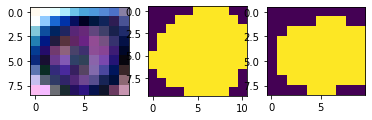

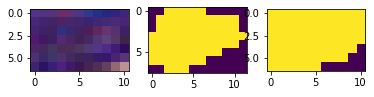

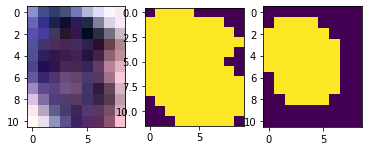

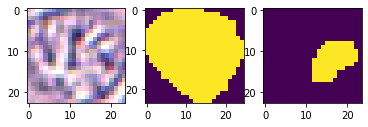

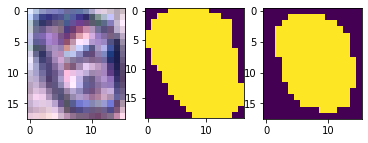

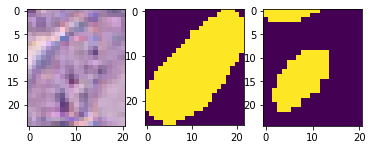

In [16]:
plt.figure()
tnbc = TNBC1()
for idx, row in df.sample(10, axis=0).iterrows():
    plt.figure()
    plt.subplot(131)
    plt.imshow(tnbc.load_image(row["image_id"])[row["obj"]])
    plt.subplot(132)
    plt.imshow(row["mask"])
    plt.subplot(133)
    plt.imshow(row["unet_mask"])

In [17]:
# Most missing cells are tumor cells
print((df[df["unet_size"] == 0]["class"].value_counts()))

tumor           20
immune cells    18
Name: class, dtype: int64


<AxesSubplot:>

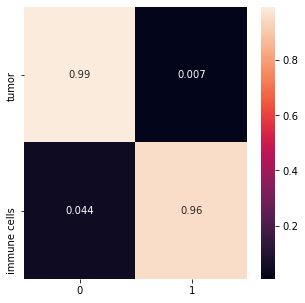

In [18]:
# Droping missing cells
df = df[df["unet_size"] > 0] 
df["pred_class"] = model.predict(df[[f"unet_{f}" for f in features]].iloc[:]).argmax(axis=1)
df["pred_class"] = df["pred_class"].apply(lambda x: classes[x])

cm = confusion_matrix(df["class"], df["pred_class"], normalize='true')
df_cm_unet = pd.DataFrame(cm, index = classes)
plt.figure(figsize=(5,5))

# Of none-missing cells most are correclty classified
sn.heatmap(df_cm_unet, annot=True)

In [21]:
# Predicting all cells

def get_objects(mask):
    all_labels = measure.label(mask, background=0)
    return find_objects(all_labels)

def make_pred_dataframe(key, mask, image):
    """ Takes an image id  and a mask
        and returns a dataframe with all cells"""
    d = []
    for obj in get_objects(mask):
        m = mask[obj]
        d.append({"image_id" : key,
                  "obj" : obj, "mask" : m})

    df_pred = pd.DataFrame(d)
    df_pred["avg_brightness"], df_pred["var_brightness"] = avg_brightness(df_pred["image_id"], df_pred["mask"], df_pred["obj"], {key: image})
    df_pred["size"] = df_pred["mask"].apply(np.sum)
    df_pred["class"] = model.predict(df_pred[features].iloc[:]).argmax(axis=1)
    df_pred["class_name"] = df_pred["class"].apply(lambda x: classes[x])
    return df_pred



In [22]:
df_pred = pd.concat([make_pred_dataframe(imid, mask, tnbc.load_image(imid))
                        for imid, mask in tqdm(masks.items())])


100%|██████████| 80/80 [01:17<00:00,  1.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-40-d5935fd5b157>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(221)
100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


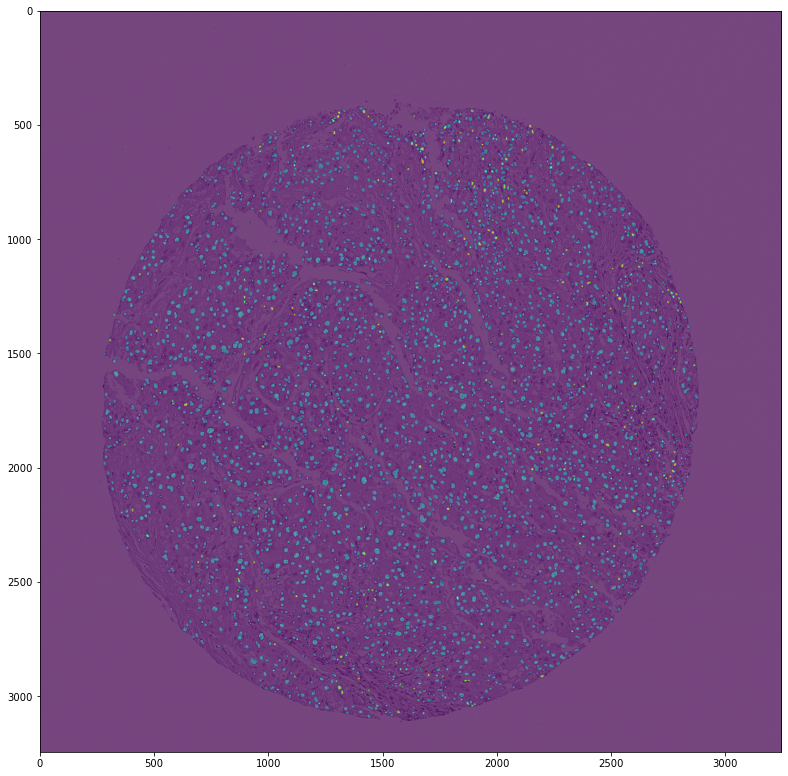

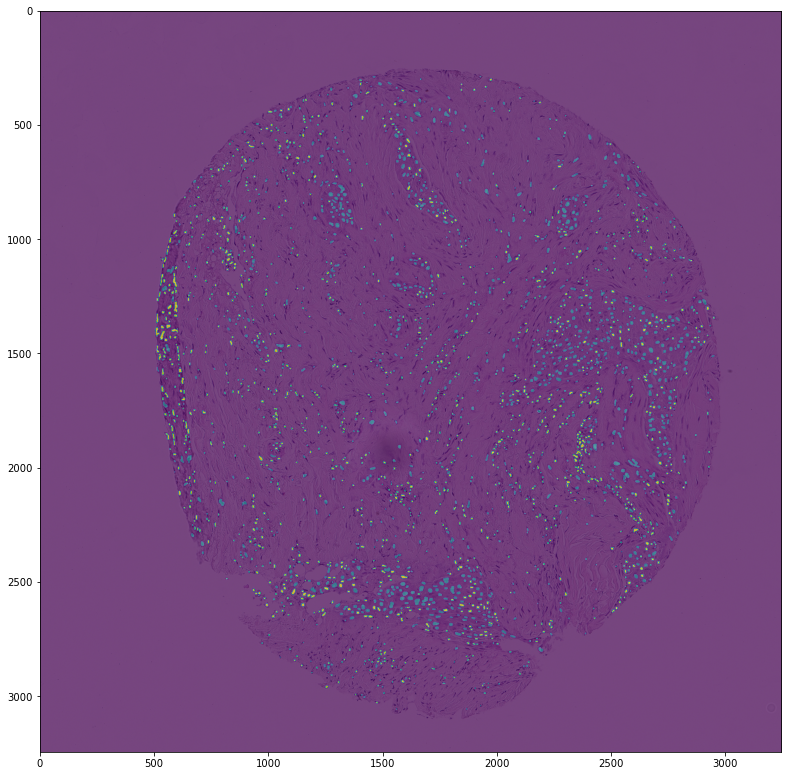

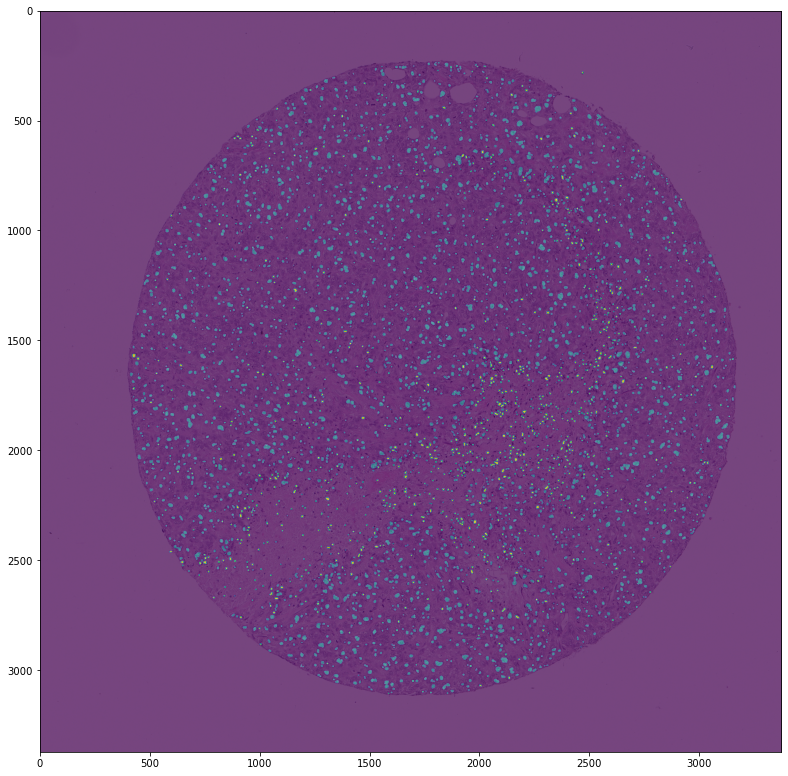

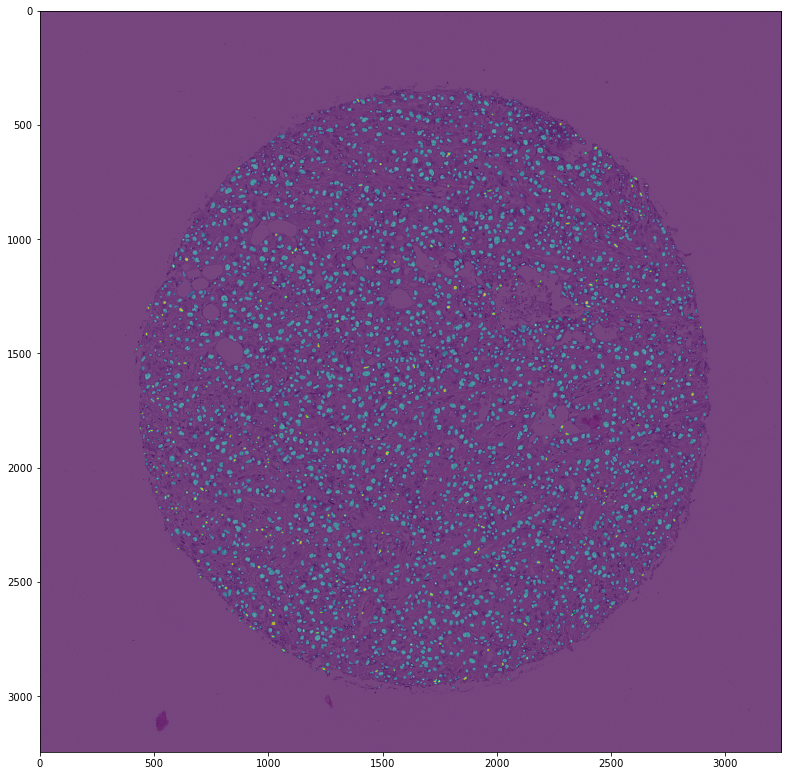

In [40]:
# Displaying results
import random
cells = {}
for imid in tqdm(random.choices(df["image_id"].unique(), k=4)):
    img = TNBC1().load_image(imid)
    pred = np.zeros((img.shape[0], img.shape[1]))
    for _, row in df_pred[df_pred["image_id"] == imid].iterrows():
        pred[row["obj"]] = (1 + row["class"]) * row["mask"]

    cells[imid] = pred
    plt.figure(figsize=(30,30))
    plt.subplot(221)
    plt.imshow(pred)
    plt.subplot(221)
    plt.imshow(img, alpha=0.3)

In [37]:
def cell_locations(df : pd.DataFrame):
    return df["obj"].apply(
        lambda x: ((x[0].start+x[0].stop)/2,
                   (x[1].start+x[1].stop)/2)).values

def make_patient_dataframe(df_pred):
    """ Returns a dataframe with one row for every image. """
    d = []
    for image_id in df_pred["image_id"].unique():
        df_imid = df_pred[df_pred["image_id"] == image_id]
        d.append(
            {
                "image_id" : image_id,
                "n_tumor" : len(df_imid[df_imid["class_name"] == "tumor"].index),
                "n_immune" : len(df_imid[df_imid["class_name"] == "immune cells"].index),
                "tumor_loc" : cell_locations(df_imid[df_imid["class_name"] == "tumor"]),
                "immune_loc" : cell_locations(df_imid[df_imid["class_name"] == "immune cells"]),
                "tumor_area" : df_imid[df_imid["class_name"] == "tumor"]["size"].sum(),
                "immune_area" : df_imid[df_imid["class_name"] == "immune cells"]["size"].sum(),
            }
        )
    return pd.DataFrame(d)

In [ ]:
df_pat = make_patient_dataframe(df_pred)
df_pat.to_csv('../data/tnbc1/tnbc_no_scaling.csv')
df_pat.to_pickle('../data/tnbc1/tnbc_no_scaling.pickle')

## Predict and classify all TNBC

In [28]:
import importlib
import dataset
from dataset import TNBC2
import keras.backend as K
importlib.reload(dataset)

tnbc = TNBC2()

dfs = []
for imid in tqdm(tnbc.ids):
    mask = post_processing(make_pred(tnbc.file_name(imid), 'unet_quip_10000', int(3*c.HEIGHT/2)))
    try:
        dfs.append(make_pred_dataframe(imid, mask, tnbc.load_image(imid)))
    except KeyError:
        continue
    K.clear_session()

df_pat = make_patient_dataframe(pd.concat(dfs))
df_pat.to_pickle('../data/tnbc2/tnbc.pickle')


 70%|███████   | 56/80 [07:06<03:02,  7.61s/it]]

100%|██████████| 541/541 [15:39<00:00,  1.74s/it]


ValueError: operands could not be broadcast together with shapes (15,17) (9,7) 

In [38]:
df_pat = make_patient_dataframe(pd.concat(dfs))
df_pat.to_pickle('../data/tnbc2/tnbc.pickle')

In [39]:
df_pat.head()

image_id  n_tumor  n_immune  \
0    TNBC_Block_5_block_1_315690_5_K_HE     1051      2163   
1  TNBC_Block_1_block_1_229588_1_A_HTX      1845      1244   
2  TNBC_Block_1_block_1_229656_6_D_HTX      2507      1016   
3  TNBC_Block_2_block_1_230464_8_F_HTX      1381      1600   
4    TNBC_Block_4_block_1_314654_4_B_HE     1862      1426   

                                           tumor_loc  \
0  [(476.5, 1865.5), (488.5, 2045.5), (526.5, 194...   
1  [(221.5, 1806.0), (224.5, 1882.5), (232.5, 176...   
2  [(292.5, 1811.5), (288.0, 1664.5), (289.5, 172...   
3  [(291.0, 1330.5), (303.0, 1328.0), (307.0, 187...   
4  [(276.0, 1698.5), (287.5, 1572.0), (296.5, 144...   

                                          immune_loc  tumor_area  immune_area  
0  [(447.5, 1988.0), (465.0, 1858.0), (470.5, 192...      224961       162728  
1  [(238.5, 2004.5), (243.5, 2013.5), (254.0, 140...      162105        51694  
2  [(289.5, 1659.5), (302.0, 1676.0), (322.5, 170...      294803        44157  
3  [(257.5, 1528.5), (267.0, 1539.5), (276.0, 177...      160362        75829  
4  [(306.0, 1619.0), (315.0, 1929.5), (312.5, 148...      206210        68444